In [1]:
from util_fdp import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

ABC_TABLE = {
    (0.25, 1):(0.51, 100, 20), 
    (0.25, 5):(0.51, 100, 20), 
    (0.25, 'log'):(0.51, 100, 20), 
    (0.9, 1): (0.51, 100, 20),
    (0.9, 5): (0.568, 0, 1),
    (0.9, 'log'): (0.782, 25, 2),
}
DEFAULT_ABC = (0.51, 100, 20)
def get_abc(E_typ: str, E_cons, r: float,
            default=DEFAULT_ABC, table=ABC_TABLE):
    """
    根据 (E_typ, E_cons, r) 返回 (a, b, c)。
    - E_typ ∈ {"cons", "log"}
    - E_cons ∈ {1, 5}  （当 E_typ == "cons" 时才使用）
    - r ∈ {0.25, 0.9}
    未匹配到时返回 default。
    """
    if gene_process == 'hete':
        key = (r, "log") if E_typ.lower() == "log" else (r, E_cons)
        return table.get(key, default)
    else:
        return (0.51, 100, 20)

# ── 必要导入 ───────────────────────────────────────────────────
from util_fdp import run_federated_trajectory
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
np.random.seed(2020)
# ── 全局设置（一次写好，到处复用）────────────────────────────
mpl.rcParams.update({
    'font.size': 13, 'axes.titlesize': 16, 'axes.labelsize': 14,
    'legend.fontsize': 12, 'lines.linewidth': 2.4,
})
COLORS = {
    'global': '#0072B2',   # 深蓝
    'c0'    : '#009E73',   # 绿
    'c1'    : '#7E79D2',   # 橙
    'ci'    : '#D55E00',   # 淡紫
}

In [2]:
# ── 抽取 & 对齐曲线到固定长度 N ───────────────────────────────
# ── 抽取曲线 (保留各自横轴) ──────────────────────────────────
def get_curves(E_typ, E_cons, N,
               *, base_seed=2020, n_clients=10,
               gene_process='hete',taus=0.5, rs=[]):
    """
    返回:
      xs_g, gavg, lo, up, true_q,
      xs_c0, c0, xs_c1, c1
    其中 xs_* 均已排序，长度各自与对应 y 一一对应。
    """
    a, b, c = get_abc(E_typ, E_cons, r)             # 动态取 abc
    true_q, traj = run_federated_trajectory(
        dist_type='normal', taus=taus,
        client_rs=rs, n_clients=n_clients, T=N,
        E_typ=E_typ, E_cons=E_cons, gene_process=gene_process,
        mode='federated',
        T_mode='samples',
        base_seed=base_seed, a=a, b=b, c=c)

    # ── Global 曲线 ──
    g_hist  = traj['global']['global_q_avg']
    v_hist  = traj['global']['global_variance']
    xs_g    = np.array(sorted(g_hist))
    gavg    = np.array([g_hist[k] for k in xs_g])
    gvar    = np.array([v_hist[k] for k in xs_g])
    z       = 6.753 if E_typ == 'log' else 6.74735
    lo, up  = gavg - z * np.sqrt(gvar), gavg + z * np.sqrt(gvar)

    # ── Client 曲线（0 与 1） ──
    c0_hist = traj['local']['client_0']
    c1_hist = traj['local']['client_1']   # ← 若用 client_2 则改这里
    xs_c0   = np.array(sorted(c0_hist))
    xs_c1   = np.array(sorted(c1_hist))
    c0      = np.array([c0_hist[k] for k in xs_c0])
    c1      = np.array([c1_hist[k] for k in xs_c1])

    return xs_g, gavg, lo, up, true_q, xs_c0, c0, xs_c1, c1

In [3]:
# ── 单子图绘制 (用各自横轴) ──────────────────────────────────
from matplotlib.ticker import FuncFormatter  # ★ 新增
def plot_panel(ax,
               xs_g, gavg, lo, up, true_q,
               xs_c0, c0, xs_c1, c1,
               *,scale=100, add_ylabel=False, add_legend=False,
               title=None, x_max=None, y_lims=None):

    ax.plot(xs_c0, c0,'-.',color=COLORS['c0'], label='Client 0')
    ax.plot(xs_c1, c1,':', color=COLORS['c1'], label='Client 1')
    ax.plot(xs_g,  gavg, color=COLORS['global'], label='Global')
    ax.plot(xs_g,  lo,   '--', color=COLORS['ci'], lw=2, label='CI bounds')
    ax.plot(xs_g,  up,   '--', color=COLORS['ci'], lw=2)
    ax.axhline(true_q, ls='--', color='gray', lw=2, label=r'True $q$')

    ax.grid(axis='y', ls=':', alpha=0.7)
    # 统一轴范围
    if x_max  is not None: 
        ax.set_xlim(0, x_max)
        formatter = FuncFormatter(lambda x, pos: f'{int(x/scale)}')
        ax.xaxis.set_major_formatter(formatter)
    
    if y_lims is not None: ax.set_ylim(*y_lims)
    ax.set_xlabel('Samples')
    if add_ylabel: ax.set_ylabel('Quantile')
    if title:      ax.set_title(title)
    if add_legend: ax.legend(frameon=False)

In [4]:
## 
tau = 0.5
gene_process = 'homo'
r = 0.9
rs = [r]*10
N       = 30_000
seed    = 1
configs = [('cons', 1),('cons', 5), ('cons', 10), ('log', 5)]
curves_all = [
    get_curves(typ, econ, N=N, base_seed=seed,
               n_clients=10,taus=tau, gene_process=gene_process,
               rs=rs)
    for typ, econ in configs
]

2025-05-15 10:45:28,380	INFO worker.py:1843 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


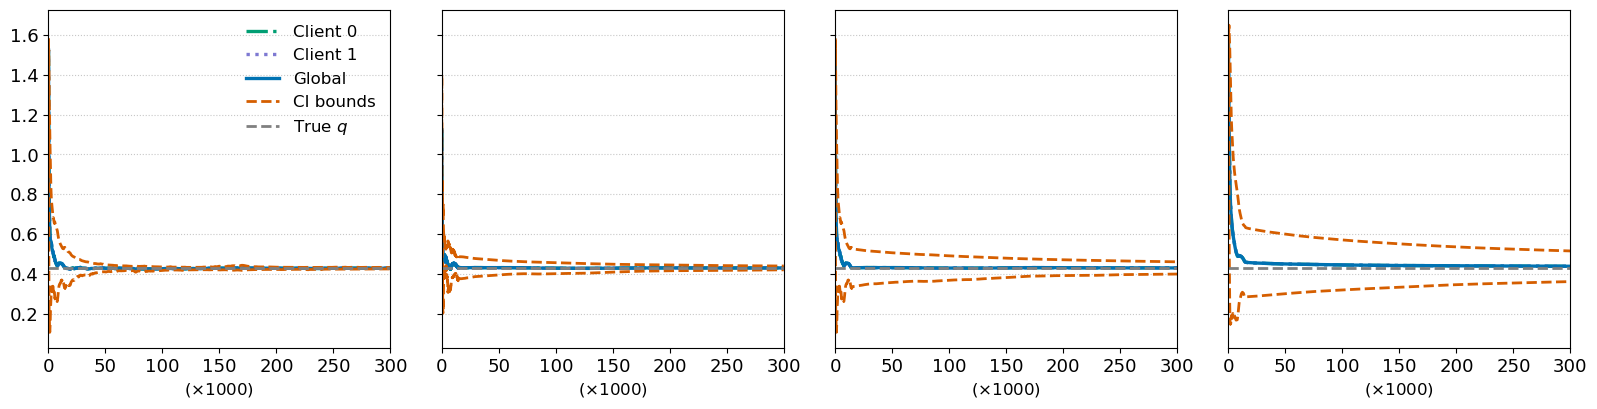

In [6]:

# ── 绘图阶段 ────────────────────────────────────────────────
configs = [('cons', 1),('cons', 5), ('cons', 10), ('log', 5)]
fig, axes = plt.subplots(1, len(configs), figsize=(4*len(configs), 4),
                         sharey=True)

for i, (ax, curves) in enumerate(zip(axes, curves_all)):
    plot_panel(ax, *curves,
               add_ylabel=False,          # 关闭 y 轴标题
               add_legend=(i == 0),       # 只在第一张放图例
               title=None,                # 关闭子图标题
               x_max=30000)      # 固定横轴上限

    # 去掉 x 轴标签
    ax.set_xlabel(r'$(\times 1000)$', fontsize=12)
    # ax.set_xlabel('')                     # 若不想留空白，可注释掉这行
    # 去掉 y 轴标签（已经通过 add_ylabel=False 实现）

# 可选：如果想让最外层整体去掉两侧多余空白
fig.tight_layout(pad=0.3)          # 图与图框之间留 0.3 英寸
fig.subplots_adjust(wspace=0.15)   # ② 调整列间距；数值越小越紧
plt.savefig(f'trace_tau_{tau}_{gene_process}_r_{r}.pdf',dpi=250)
plt.show()

In [7]:
## 
tau = 0.3
gene_process = 'homo'
r = 0.9
rs = [r]*10
configs = [('cons', 1)]
N       = 20_000
seed    = 1

In [ ]:
configs = [('cons', 1)]
curves_1 = [
    get_curves(typ, econ, N=30000, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

configs = [('cons', 5), ('cons', 10), ('log', 5)]
curves_all_1 = [
    get_curves(typ, econ, N=N, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

curves_all = curves_1 + curves_all_1


# ── 绘图阶段 ────────────────────────────────────────────────
configs = [('cons', 1),('cons', 5), ('cons', 10), ('log', 5)]
fig, axes = plt.subplots(1, len(configs), figsize=(4*len(configs), 4),
                         sharey=True)

for i, (ax, curves) in enumerate(zip(axes, curves_all)):
    plot_panel(ax, *curves,
               add_ylabel=False,          # 关闭 y 轴标题
               add_legend=(i == 0),       # 只在第一张放图例
               title=None,                # 关闭子图标题
               x_max=30000, y_lims=(-0.8,-0.2))      # 固定横轴上限

    # 去掉 x 轴标签
    ax.set_xlabel(r'$(\times 1000)$', fontsize=12)
    # ax.set_xlabel('')                     # 若不想留空白，可注释掉这行
    # 去掉 y 轴标签（已经通过 add_ylabel=False 实现）

# 可选：如果想让最外层整体去掉两侧多余空白
fig.tight_layout(pad=0.3)          # 图与图框之间留 0.3 英寸
fig.subplots_adjust(wspace=0.15)   # ② 调整列间距；数值越小越紧
plt.savefig(f'trace_tau_{tau}_{gene_process}_r_{r}.pdf',dpi=250)
plt.show()

In [24]:
## 
tau = 0.8
gene_process = 'homo'
r = 0.9
rs = [r]*10
configs = [('cons', 1)]
N       = 20_000
seed    = 2

In [25]:
configs = [('cons', 1)]
curves_1 = [
    get_curves(typ, econ, N=20000, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

In [26]:
configs = [('cons', 5), ('cons', 10), ('log', 5)]
curves_all_1 = [
    get_curves(typ, econ, N=N, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

curves_all = curves_1 + curves_all_1

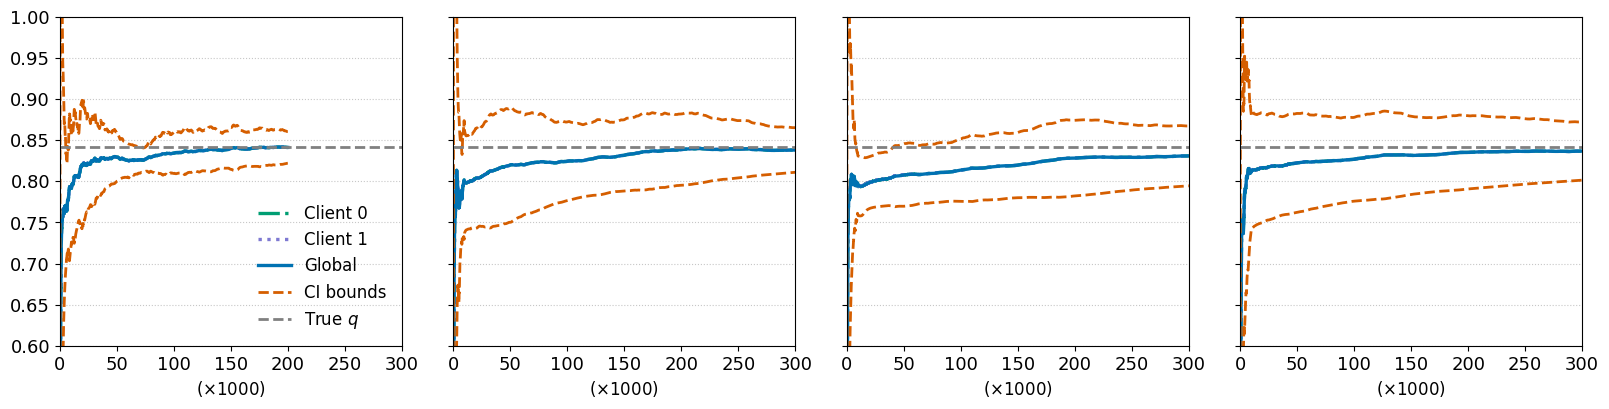

In [27]:
# ── 绘图阶段 ────────────────────────────────────────────────
configs = [('cons', 1),('cons', 5), ('cons', 10), ('log', 5)]
fig, axes = plt.subplots(1, len(configs), figsize=(4*len(configs), 4),
                         sharey=True)

for i, (ax, curves) in enumerate(zip(axes, curves_all)):
    plot_panel(ax, *curves,
               add_ylabel=False,          # 关闭 y 轴标题
               add_legend=(i == 0),       # 只在第一张放图例
               title=None,                # 关闭子图标题
               x_max=30000, y_lims=(0.6,1.0))      # 固定横轴上限

    # 去掉 x 轴标签
    ax.set_xlabel(r'$(\times 1000)$', fontsize=12)
    # ax.set_xlabel('')                     # 若不想留空白，可注释掉这行
    # 去掉 y 轴标签（已经通过 add_ylabel=False 实现）

# 可选：如果想让最外层整体去掉两侧多余空白
fig.tight_layout(pad=0.3)          # 图与图框之间留 0.3 英寸
fig.subplots_adjust(wspace=0.15)   # ② 调整列间距；数值越小越紧
plt.savefig(f'trace_tau_{tau}_{gene_process}_r_{r}.pdf',dpi=250)
plt.show()

In [ ]:
## 
tau = 0.5
gene_process = 'homo'
rs = np.linspace(0.25, 0.9, 10).tolist()
configs = [('cons', 1)]
N       = 20_000
# seed    = 3
seed    = 10

configs = [('cons', 1)]
curves_1 = [
    get_curves(typ, econ, N=30000, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

configs = [('cons', 5), ('cons', 10), ('log', 5)]
curves_all_1 = [
    get_curves(typ, econ, N=N, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

curves_all = curves_1 + curves_all_1

# ── 绘图阶段 ────────────────────────────────────────────────
configs = [('cons', 1),('cons', 5), ('cons', 10), ('log', 5)]
fig, axes = plt.subplots(1, len(configs), figsize=(4*len(configs), 4),
                         sharey=True)

for i, (ax, curves) in enumerate(zip(axes, curves_all)):
    plot_panel(ax, *curves,
               add_ylabel=False,          # 关闭 y 轴标题
               add_legend=(i == 0),       # 只在第一张放图例
               title=None,                # 关闭子图标题
               x_max=30000, y_lims=(-0.15,0.15))      # 固定横轴上限

    # 去掉 x 轴标签
    ax.set_xlabel(r'$(\times 1000)$', fontsize=12)
    # ax.set_xlabel('')                     # 若不想留空白，可注释掉这行
    # 去掉 y 轴标签（已经通过 add_ylabel=False 实现）

# 可选：如果想让最外层整体去掉两侧多余空白
fig.tight_layout(pad=0.3)          # 图与图框之间留 0.3 英寸
fig.subplots_adjust(wspace=0.15)   # ② 调整列间距；数值越小越紧
plt.savefig(f'trace_tau_{tau}_{gene_process}_r_hete.pdf',dpi=250)
plt.show()

In [ ]:
## 
tau = 0.3
gene_process = 'homo'
rs = np.linspace(0.25, 0.9, 10).tolist()
configs = [('cons', 1)]
N       = 20_000
# seed    = 3
seed    = 10

configs = [('cons', 1)]
curves_1 = [
    get_curves(typ, econ, N=30000, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

configs = [('cons', 5), ('cons', 10), ('log', 5)]
curves_all_1 = [
    get_curves(typ, econ, N=N, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

curves_all = curves_1 + curves_all_1

# ── 绘图阶段 ────────────────────────────────────────────────
configs = [('cons', 1),('cons', 5), ('cons', 10), ('log', 5)]
fig, axes = plt.subplots(1, len(configs), figsize=(4*len(configs), 4),
                         sharey=True)

for i, (ax, curves) in enumerate(zip(axes, curves_all)):
    plot_panel(ax, *curves,
               add_ylabel=False,          # 关闭 y 轴标题
               add_legend=(i == 0),       # 只在第一张放图例
               title=None,                # 关闭子图标题
               x_max=30000, y_lims=(-0.8,-0.2))      # 固定横轴上限

    # 去掉 x 轴标签
    ax.set_xlabel(r'$(\times 1000)$', fontsize=12)
    # ax.set_xlabel('')                     # 若不想留空白，可注释掉这行
    # 去掉 y 轴标签（已经通过 add_ylabel=False 实现）

# 可选：如果想让最外层整体去掉两侧多余空白
fig.tight_layout(pad=0.3)          # 图与图框之间留 0.3 英寸
fig.subplots_adjust(wspace=0.15)   # ② 调整列间距；数值越小越紧
plt.savefig(f'trace_tau_{tau}_{gene_process}_r_hete.pdf',dpi=250)
plt.show()

In [93]:
## 
tau = 0.8
gene_process = 'homo'
rs = np.linspace(0.25, 0.9, 10).tolist()
configs = [('cons', 1)]
N       = 20_000
# seed    = 3
seed    = 10

configs = [('cons', 1)]
curves_1 = [
    get_curves(typ, econ, N=30000, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

configs = [('cons', 5), ('cons', 10), ('log', 5)]
curves_all_1 = [
    get_curves(typ, econ, N=N, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

curves_all = curves_1 + curves_all_1

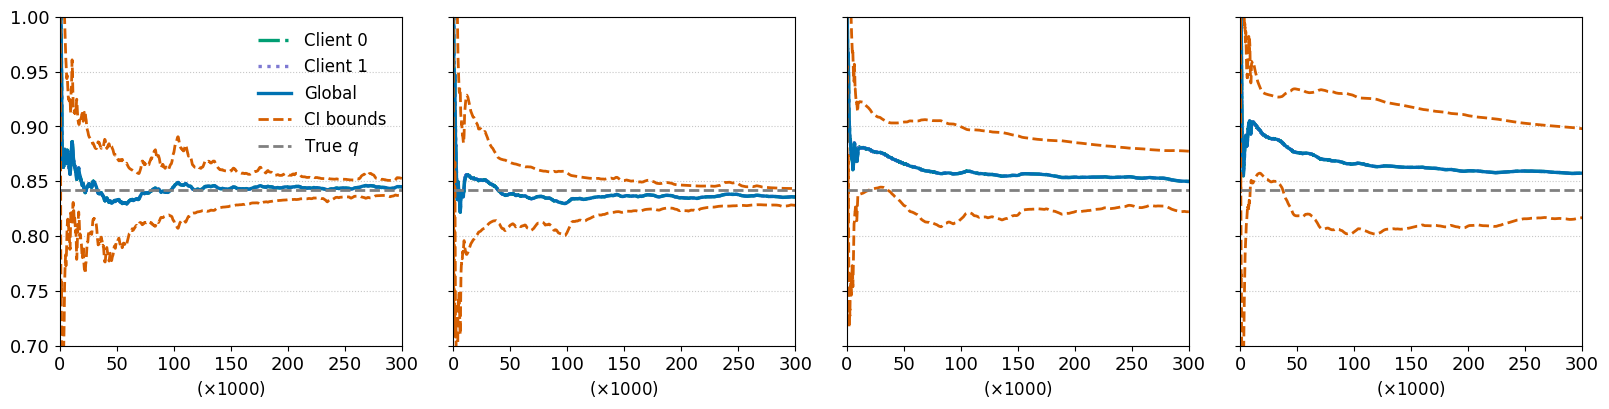

In [96]:
# ── 绘图阶段 ────────────────────────────────────────────────
configs = [('cons', 1),('cons', 5), ('cons', 10), ('log', 5)]
fig, axes = plt.subplots(1, len(configs), figsize=(4*len(configs), 4),
                         sharey=True)

for i, (ax, curves) in enumerate(zip(axes, curves_all)):
    plot_panel(ax, *curves,
               add_ylabel=False,          # 关闭 y 轴标题
               add_legend=(i == 0),       # 只在第一张放图例
               title=None,                # 关闭子图标题
               x_max=30000,y_lims=(0.7,1.0))      # 固定横轴上限

    # 去掉 x 轴标签
    ax.set_xlabel(r'$(\times 1000)$', fontsize=12)
    # ax.set_xlabel('')                     # 若不想留空白，可注释掉这行
    # 去掉 y 轴标签（已经通过 add_ylabel=False 实现）

# 可选：如果想让最外层整体去掉两侧多余空白
fig.tight_layout(pad=0.3)          # 图与图框之间留 0.3 英寸
fig.subplots_adjust(wspace=0.15)   # ② 调整列间距；数值越小越紧
plt.savefig(f'trace_tau_{tau}_{gene_process}_r_hete.pdf',dpi=250)
plt.show()